In [1]:
import torchhd
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from functools import partial


In [2]:
VSA_TYPES = ['FHRR', 'BSC', 'MAP', 'HRR']
DIMENSIONS = [2**i for i in range(6, 11)]
BUNDLE_SIZES = list(range(2, 200, 2))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    torch.cuda.empty_cache()

batches = 10
item_memory_size = 10_000
MAX_BUNDLE_SIZE = BUNDLE_SIZES[-1]

In [3]:
def norm_hamming_similarity(x, y):
    normalisation_factor = x.shape[1] if x.ndim == 2 else x.shape[0]
    sim = torchhd.hamming_similarity(x, y)
    norm_sim = sim / normalisation_factor
    return norm_sim

def similarity_func_partial(vsa_type, x, y):
    if vsa_type == 'BSC':
        return norm_hamming_similarity(x, y)
    else:
        return torchhd.cosine_similarity(x, y)

# Evaluating non-normalized capacity of HD vectors

In [4]:
prob_correct_tensor = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), len(VSA_TYPES), batches)

for vsa_type_idx in tqdm(range(len(VSA_TYPES))):
  vsa_type = VSA_TYPES[vsa_type_idx]
  print(f'vsa type: {vsa_type}')
  similarity_func = partial(similarity_func_partial, vsa_type)

  for batch in range(batches):
        perc_corr_array = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES))
        # print(f'iteration: {batch + 1}')

        for d_idx in tqdm(range(len(DIMENSIONS)), disable=True):
            dim = DIMENSIONS[d_idx]
            item_memory = torchhd.random(item_memory_size, dim, vsa=vsa_type, device=device)

            # Sample MAX_BUNDLE_SIZE vectors from item memory for experiment
            random_indices = torch.randperm(item_memory_size)[:MAX_BUNDLE_SIZE]
            experiment_to_bundle_vectors = item_memory[random_indices]

            for k_idx in range(len(BUNDLE_SIZES)):
                k = BUNDLE_SIZES[k_idx]

                # sample k vectors from item memory and bundle them (non-sequential)
                to_bundle_vectors = experiment_to_bundle_vectors[:k]

                bundle_vector = torchhd.multiset(to_bundle_vectors)

                # find the k nearest vectors to bundle
                similarities = similarity_func(bundle_vector, item_memory)
                k_nearest_vectors_idx = torch.topk(similarities, k, largest=True).indices

                # check how many of the k nearest vectors are correct
                num_correct = np.intersect1d(k_nearest_vectors_idx.cpu().numpy(), random_indices.cpu().numpy()).shape[0]

                perc_corr_array[d_idx, k_idx] = num_correct / k
        
        # print(perc_corr_array)
        prob_correct_tensor[:, :, vsa_type_idx, batch] = perc_corr_array
   
# compute mean and std over batches
prob_correct_mean = torch.mean(prob_correct_tensor, dim=3)
prob_correct_std = torch.std(prob_correct_tensor, dim=3)

  0%|          | 0/4 [00:00<?, ?it/s]

vsa type: FHRR


 25%|██▌       | 1/4 [00:11<00:33, 11.01s/it]

vsa type: BSC


 50%|█████     | 2/4 [00:16<00:15,  7.69s/it]

vsa type: MAP


 75%|███████▌  | 3/4 [00:21<00:06,  6.53s/it]

vsa type: HRR


100%|██████████| 4/4 [00:26<00:00,  6.74s/it]


### Line plots for each vsa type

[64, 128, 256, 512, 1024]


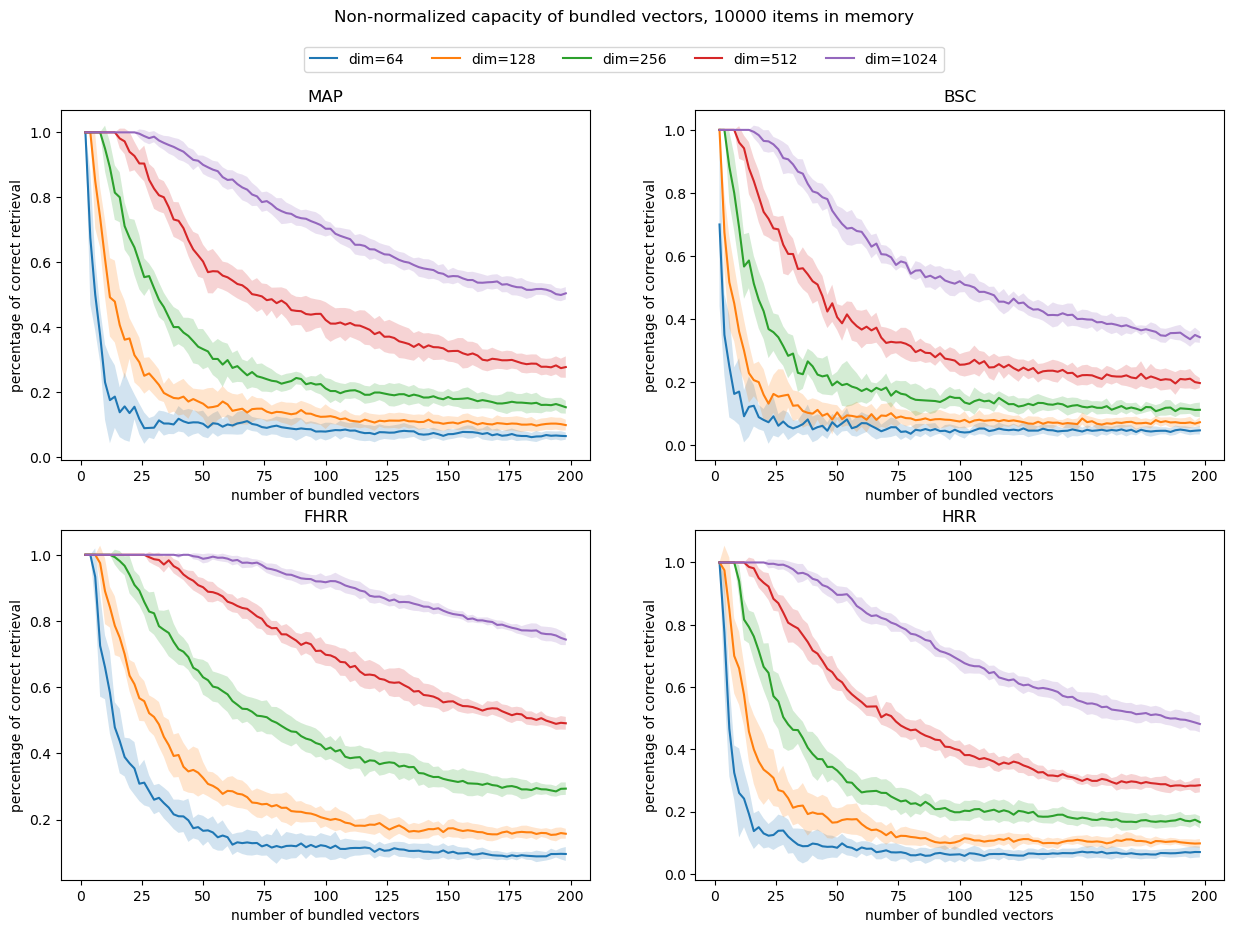

In [5]:
fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Non-normalized capacity of bundled vectors, {item_memory_size} items in memory')
print(DIMENSIONS)
for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx+1) // 2 - 1
    col = vsa_type_idx % 2
    for dim_idx in range(len(DIMENSIONS)):
        ax[row, col].plot(BUNDLE_SIZES, prob_correct_mean[dim_idx, :, vsa_type_idx], label=f'dim={DIMENSIONS[dim_idx]}')
        ax[row, col].fill_between(BUNDLE_SIZES, prob_correct_mean[dim_idx, :, vsa_type_idx] - prob_correct_std[dim_idx, :, vsa_type_idx], prob_correct_mean[dim_idx, :, vsa_type_idx] + prob_correct_std[dim_idx, :, vsa_type_idx], alpha=0.2)
    ax[row, col].set_title(vsa_type)
    ax[row, col].set_xlabel('number of bundled vectors')
    ax[row, col].set_ylabel('percentage of correct retrieval')
fig.legend(handles=ax[0, 0].get_lines(), labels=[f'dim={dim}' for dim in DIMENSIONS], ncol=len(DIMENSIONS), loc='upper center', bbox_to_anchor=(0.5, .95)) 

### Heatmaps for each vsa type

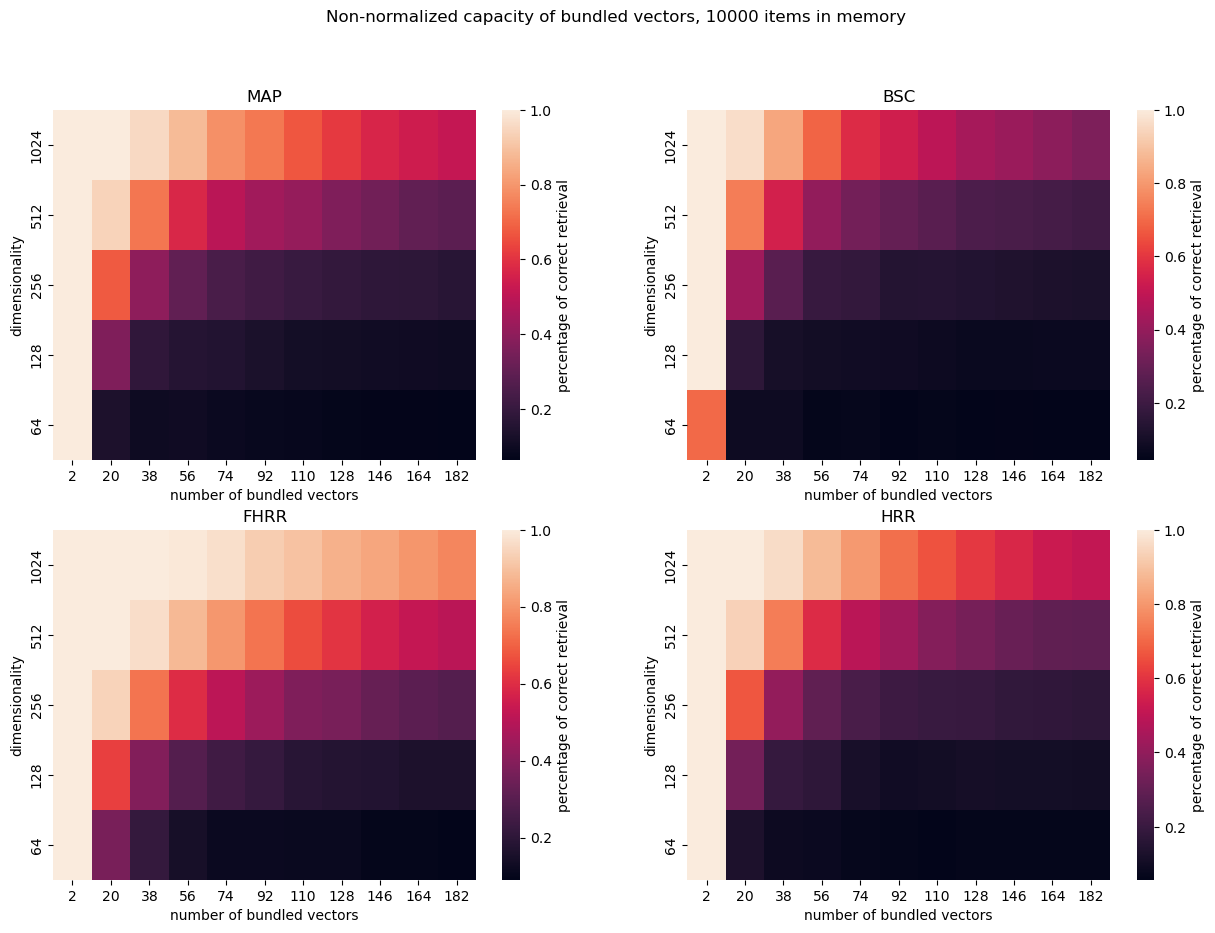

In [6]:
fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Non-normalized capacity of bundled vectors, {item_memory_size} items in memory')
for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx +1) // 2 - 1
    col = vsa_type_idx % 2
    ax[row, col].set_title(vsa_type)
    ax[row, col] = sns.heatmap(prob_correct_mean.numpy()[::-1, ::len(BUNDLE_SIZES)//10, vsa_type_idx], ax=ax[row, col], xticklabels=BUNDLE_SIZES[::len(BUNDLE_SIZES)//10], yticklabels=DIMENSIONS[::-1], cbar_kws={'label': 'percentage of correct retrieval'})
    ax[row, col].set_xlabel('number of bundled vectors')
    ax[row, col].set_ylabel('dimensionality')


## First vector similarity study using non-sequentially bundled HD vectors

In [7]:
# similarity to first vector
sim_first_vector_tensor = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), len(VSA_TYPES), batches)
# probability of retrieval of first vector
retrieval_first_vector_tensor = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), len(VSA_TYPES), batches)

for vsa_type_idx in tqdm(range(len(VSA_TYPES))):
  vsa_type = VSA_TYPES[vsa_type_idx]
  print(f'vsa type: {vsa_type}')
  similarity_func = partial(similarity_func_partial, vsa_type)
  for batch in range(batches):
      sim_first_vector_array = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES))
      retrieval_first_vector_array = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES))
      # print(f'iteration: {batch + 1}')

      for d_idx in tqdm(range(len(DIMENSIONS)), disable=True):
          dim = DIMENSIONS[d_idx]
          item_memory = torchhd.random(item_memory_size, dim, vsa=vsa_type, device=device)

          # sample MAX_BUNDLE_SIZE vectors from item memory
          random_indices = torch.randperm(item_memory_size)[:MAX_BUNDLE_SIZE]
          experiment_to_bundle_vectors = item_memory[random_indices]
          first_vector = experiment_to_bundle_vectors[0]

          for k_idx in range(len(BUNDLE_SIZES)):
              k = BUNDLE_SIZES[k_idx]

              # sample k vectors from item memory and bundle them (non-sequential)
              to_bundle_vectors = experiment_to_bundle_vectors[:k]

              bundle_vector = torchhd.multiset(to_bundle_vectors)
              
              # add similarity of first vector to bundle to array
              sim_first_vector_array[d_idx, k_idx] = similarity_func(first_vector, bundle_vector)

              # find the k nearest vectors to bundle
              similarities = similarity_func(bundle_vector, item_memory)
              k_nearest_vectors_idx = torch.topk(similarities, k, largest=True).indices

              # check if the first vector is in the k nearest vectors
              retrieval_first_vector_array[d_idx, k_idx] = 1 if random_indices[0] in k_nearest_vectors_idx else 0

      sim_first_vector_tensor[:, :, vsa_type_idx, batch] = sim_first_vector_array
      retrieval_first_vector_tensor[:, :, vsa_type_idx, batch] = retrieval_first_vector_array

# compute mean and std over batches
sim_first_vector_mean = torch.mean(sim_first_vector_tensor, dim=3)
sim_first_vector_std = torch.std(sim_first_vector_tensor, dim=3)

retrieval_first_vector_mean = torch.mean(retrieval_first_vector_tensor, dim=3)
retrieval_first_vector_std = torch.std(retrieval_first_vector_tensor, dim=3) # is this relevant?

  0%|          | 0/4 [00:00<?, ?it/s]

vsa type: FHRR


 25%|██▌       | 1/4 [00:15<00:47, 15.82s/it]

vsa type: BSC


 50%|█████     | 2/4 [00:24<00:22, 11.38s/it]

vsa type: MAP


 75%|███████▌  | 3/4 [00:33<00:10, 10.29s/it]

vsa type: HRR


100%|██████████| 4/4 [00:40<00:00, 10.20s/it]


## Line plots for each vsa type

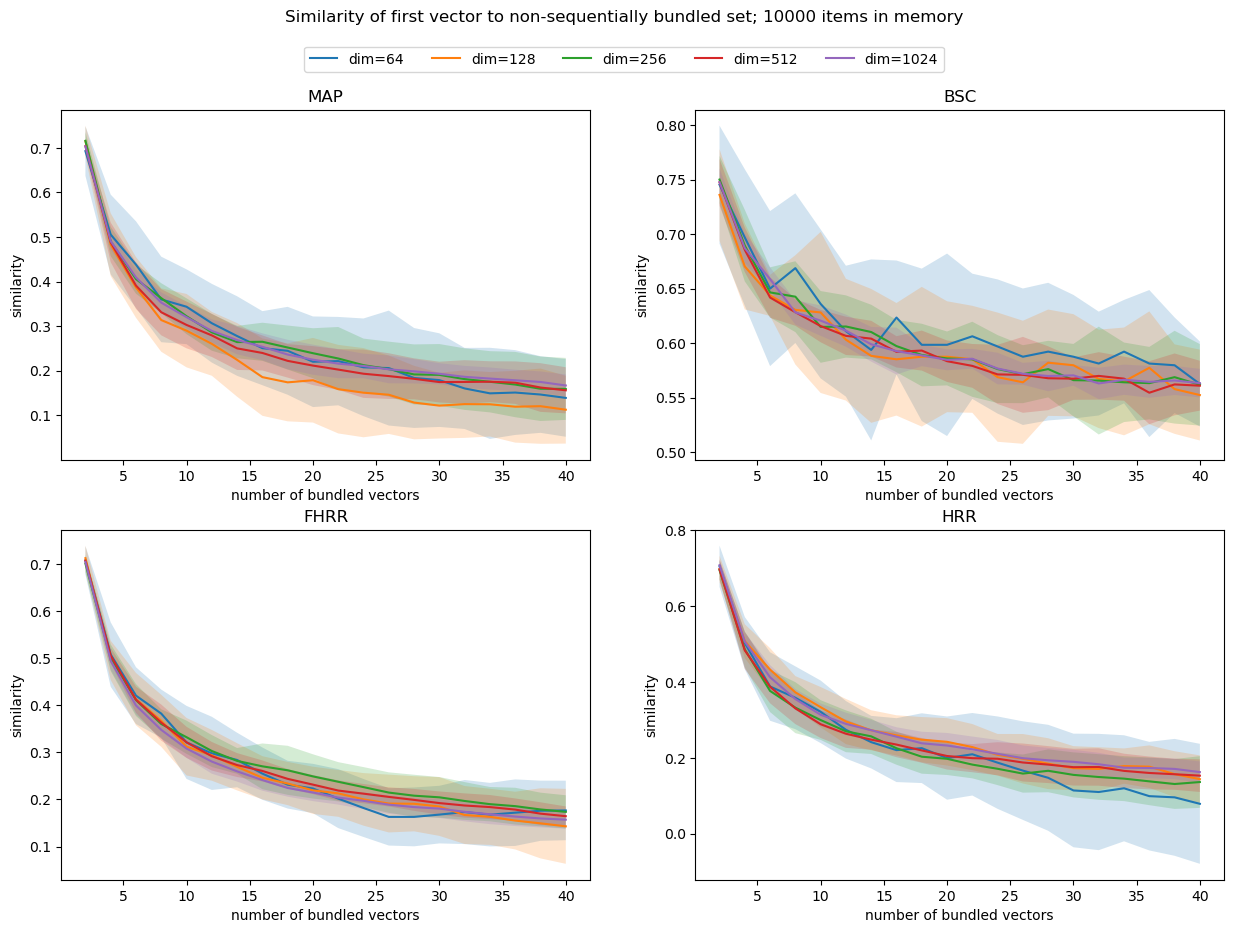

In [15]:
fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Similarity of first vector to non-sequentially bundled set; {item_memory_size} items in memory')
MAX_BUNDLE_SIZE_IDX = 20
for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx +1) // 2 - 1
    col = vsa_type_idx % 2
    ax[row, col].set_title(vsa_type)
    for dim_idx in range(len(DIMENSIONS)):
        ax[row, col].plot(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], sim_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], label=f'dim={DIMENSIONS[dim_idx]}')
        ax[row, col].fill_between(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], sim_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] - sim_first_vector_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], sim_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] + sim_first_vector_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], alpha=0.2)
    ax[row, col].set_xlabel('number of bundled vectors')
    ax[row, col].set_ylabel('similarity')
fig.legend(handles=ax[0, 0].get_lines(), labels=[f'dim={dim}' for dim in DIMENSIONS], ncol=len(DIMENSIONS), loc='upper center', bbox_to_anchor=(0.5, .95)) 
    

### Heatmaps for each vsa type

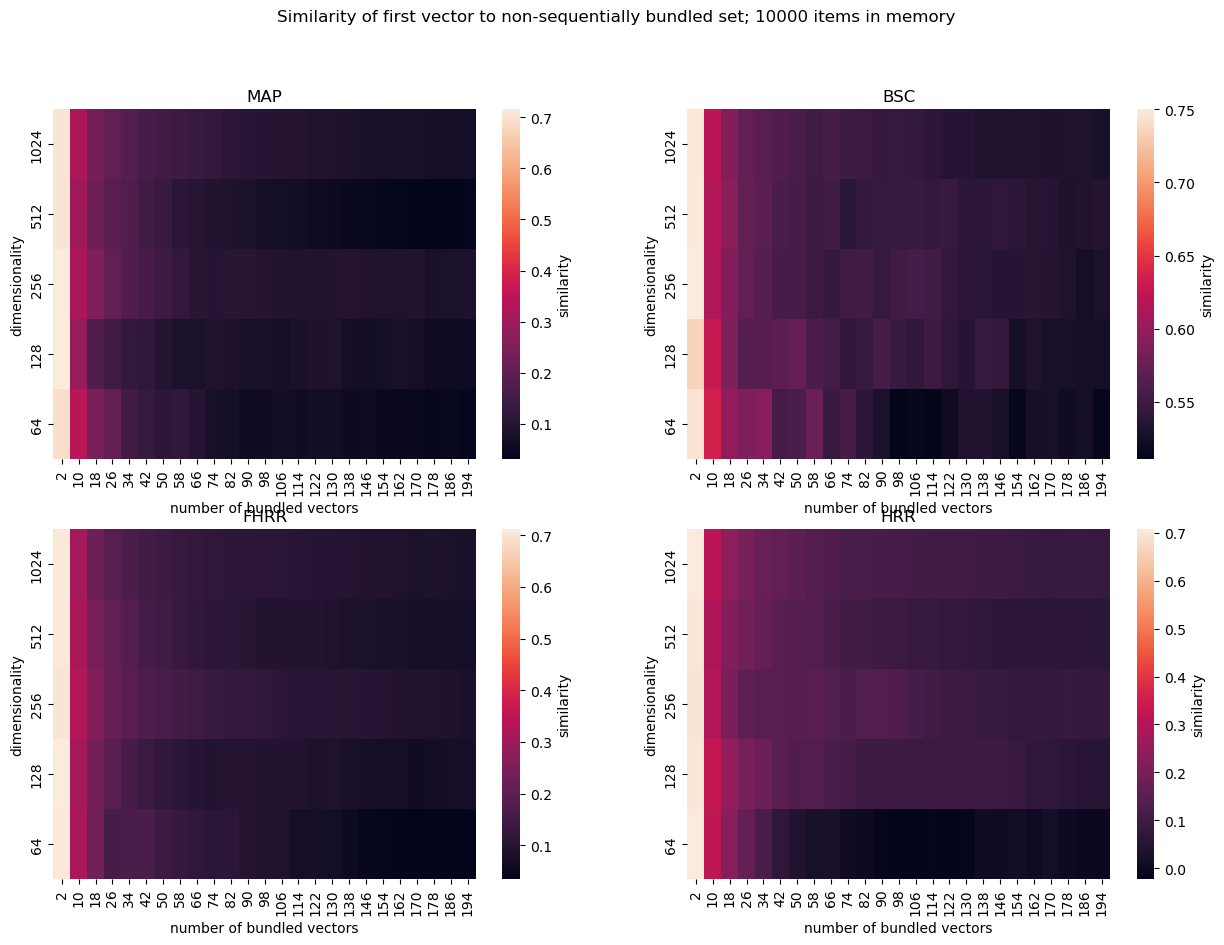

In [9]:
fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Similarity of first vector to non-sequentially bundled set; {item_memory_size} items in memory')

for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx +1) // 2 - 1
    col = vsa_type_idx % 2
    ax[row, col].set_title(vsa_type)
    ax[row, col] = sns.heatmap(sim_first_vector_mean.numpy()[::-1, ::len(BUNDLE_SIZES)//20, vsa_type_idx], ax=ax[row, col], xticklabels=BUNDLE_SIZES[::len(BUNDLE_SIZES)//20], yticklabels=DIMENSIONS[::-1], cbar_kws={'label': 'similarity'})
    ax[row, col].set_xlabel('number of bundled vectors')
    ax[row, col].set_ylabel('dimensionality')
  

Why is this not a problem, and actually to be expected?

### Line plots for each vsa type

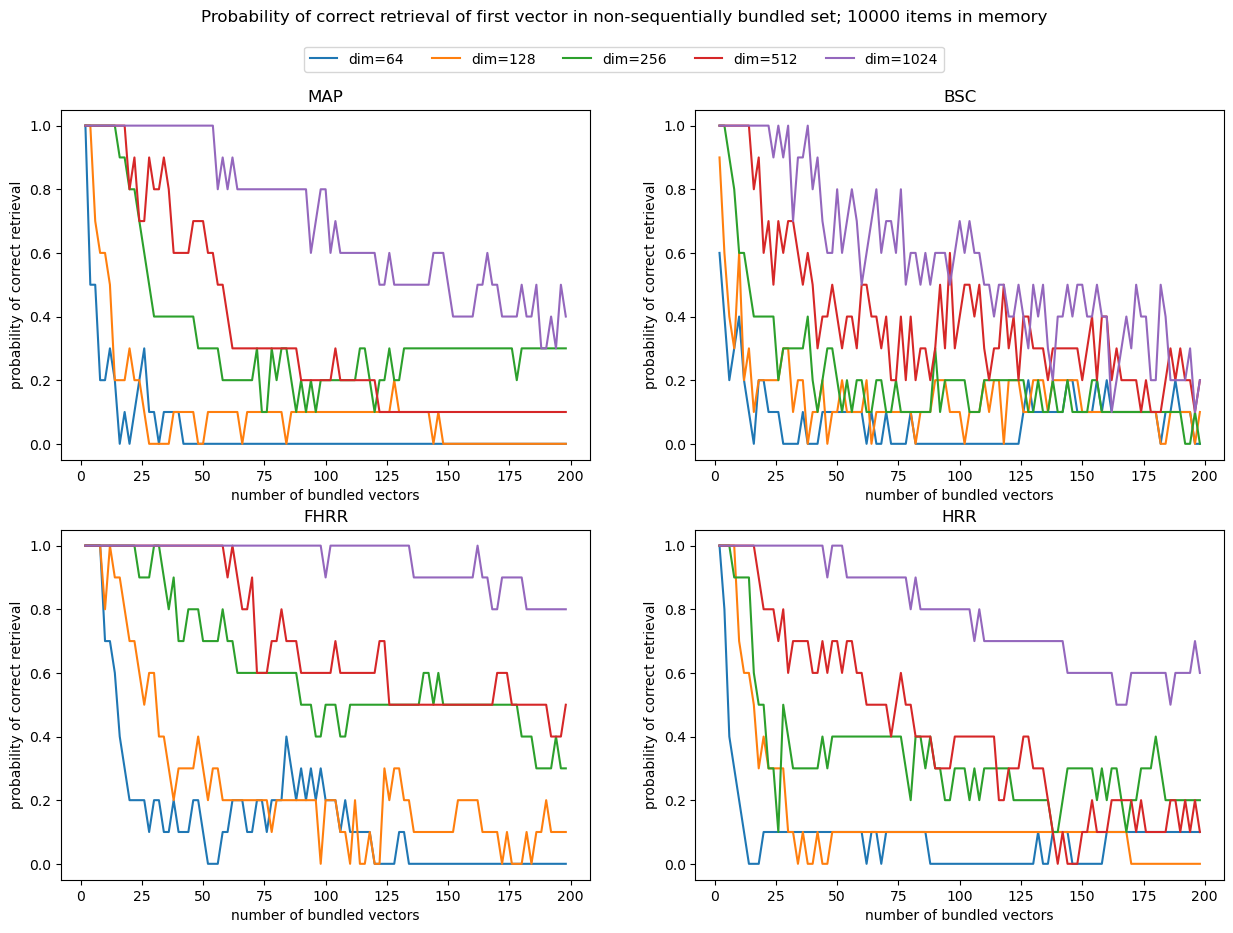

In [10]:
fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Probability of correct retrieval of first vector in non-sequentially bundled set; {item_memory_size} items in memory')

for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx +1) // 2 - 1
    col = vsa_type_idx % 2
    ax[row, col].set_title(vsa_type)
    for dim_idx in range(len(DIMENSIONS)):
        ax[row, col].plot(BUNDLE_SIZES, retrieval_first_vector_mean[dim_idx, :, vsa_type_idx], label=f'dim={DIMENSIONS[dim_idx]}')
        # ax[row, col].fill_between(BUNDLE_SIZES, retrieval_first_vector_mean[dim_idx, :, vsa_type_idx] - retrieval_first_vector_std[dim_idx, :, vsa_type_idx], retrieval_first_vector_mean[dim_idx, :, vsa_type_idx] + retrieval_first_vector_std[dim_idx, :, vsa_type_idx], alpha=0.2)
    ax[row, col].set_xlabel('number of bundled vectors')
    ax[row, col].set_ylabel('probability of correct retrieval')
fig.legend(handles=ax[0, 0].get_lines(), labels=[f'dim={dim}' for dim in DIMENSIONS], ncol=len(DIMENSIONS), loc='upper center', bbox_to_anchor=(0.5, .95)) 

### Heatmaps for each vsa type

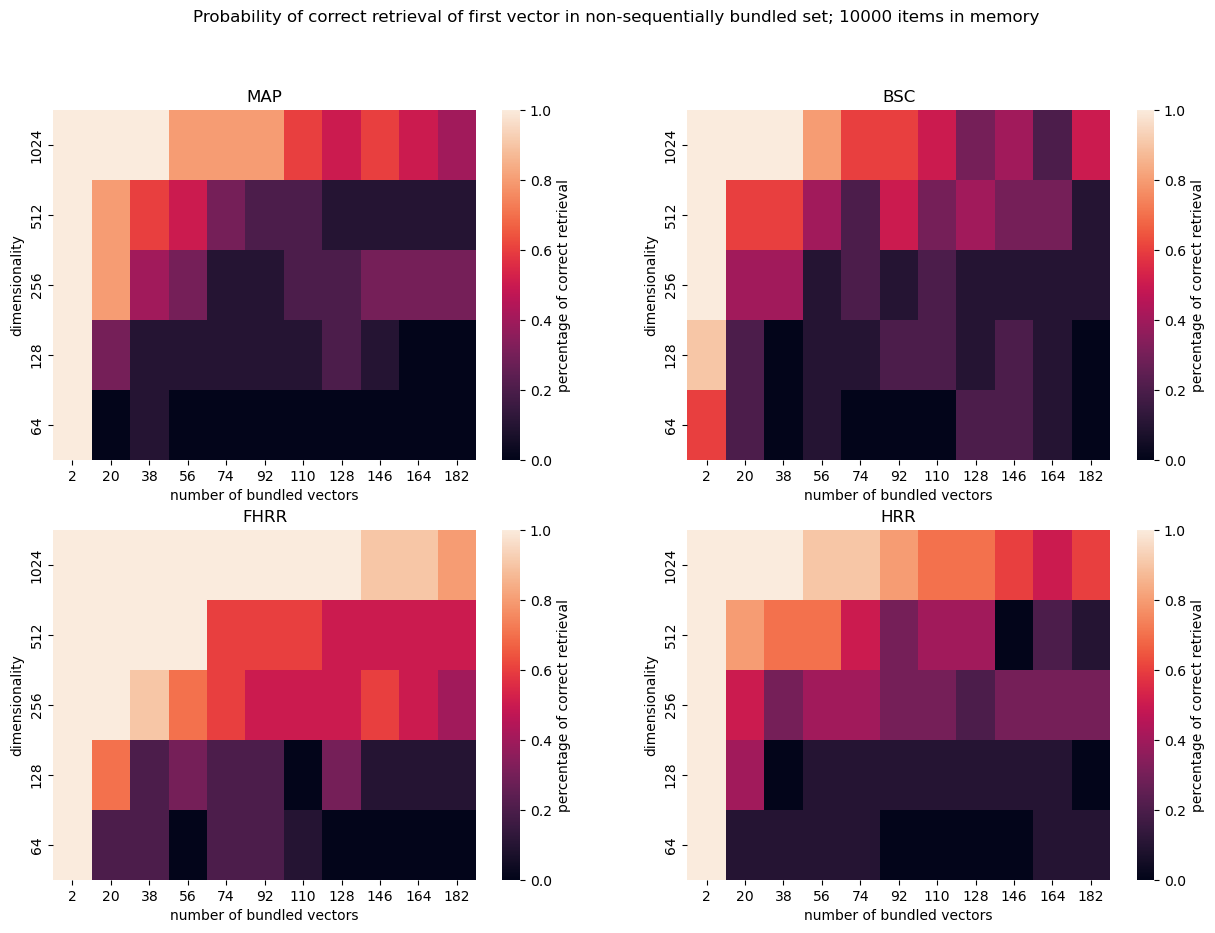

In [11]:
fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Probability of correct retrieval of first vector in non-sequentially bundled set; {item_memory_size} items in memory')

for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx +1) // 2 - 1
    col = vsa_type_idx % 2
    ax[row, col].set_title(vsa_type)
    ax[row, col] = sns.heatmap(retrieval_first_vector_mean.numpy()[::-1, ::len(BUNDLE_SIZES)//10, vsa_type_idx], ax=ax[row, col], xticklabels=BUNDLE_SIZES[::len(BUNDLE_SIZES)//10], yticklabels=DIMENSIONS[::-1], cbar_kws={'label': 'percentage of correct retrieval'})
    ax[row, col].set_xlabel('number of bundled vectors')
    ax[row, col].set_ylabel('dimensionality')